In [39]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

CatBoost is based on the gradient boosting algorithm and is particularly known for handling categorical features effectively without needing extensive preprocessing.

In [40]:
df.columns.tolist()

['id',
 'name',
 'number_of_seasons',
 'number_of_episodes',
 'original_language',
 'vote_count',
 'vote_average',
 'overview',
 'adult',
 'backdrop_path',
 'first_air_date',
 'last_air_date',
 'homepage',
 'in_production',
 'original_name',
 'popularity',
 'poster_path',
 'type',
 'status',
 'tagline',
 'genres',
 'created_by',
 'languages',
 'networks',
 'origin_country',
 'spoken_languages',
 'production_companies',
 'production_countries',
 'episode_run_time']

In [12]:
import numpy as np
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features and target variable
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 
        'vote_average', 'episode_run_time', 'original_language', 'adult', 'type',
        'status', 'genres', 'created_by', 'languages', 'networks', 'origin_country', 'spoken_languages',
        'production_companies', 'production_countries']]
y = df['popularity']

# Fill missing values in numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill missing values in categorical columns with a placeholder (e.g., 'Unknown')
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# Remove duplicates
df = df.drop_duplicates()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select categorical columns based on dtype or unique values
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
# Alternatively, use the unique value threshold approach
# cat_features = [col for col in X.columns if X[col].nunique() < unique_threshold]

# Convert categorical column names to indices for use in CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]

# Initialize Pool with identified categorical features
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features_indices)
test_pool = Pool(data=X_test, cat_features=cat_features_indices)

# Specify the training parameters
model = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE', random_seed=42, silent=True)

# Train the model
model.fit(train_pool)

# Make predictions
preds_train = model.predict(train_pool)
preds_test = model.predict(test_pool)

# Evaluate model performance
train_mae = mean_absolute_error(y_train, preds_train)
train_mse = mean_squared_error(y_train, preds_train)
train_r2 = r2_score(y_train, preds_train)

test_mae = mean_absolute_error(y_test, preds_test)
test_mse = mean_squared_error(y_test, preds_test)
test_r2 = r2_score(y_test, preds_test)

# Print evaluation metrics
print("CatBoost Regressor Results:")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R^2: {test_r2:.4f}")

CatBoost Regressor Results:
Train MAE: 4.1775
Train MSE: 607.0526
Train R^2: 0.6934
Test MAE: 4.7353
Test MSE: 757.3446
Test R^2: 0.2370


In [41]:
import numpy as np
import pandas as pd
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

# Drop duplicates before transformations
df = df.drop_duplicates()

# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation to numerical columns directly
for col in numerical_columns:
    df[col] = np.log1p(df[col])  # Apply log1p transformation directly to the existing columns

# Fill missing values in each numerical column separately to avoid dimension mismatch
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].mean())

# Fill missing values in categorical columns with a placeholder (e.g., 'Unknown')
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.05  # 95th percentile

# Winsorize each numerical column directly
for col in numerical_columns:
    # Ensure no NaNs are in the column before winsorizing
    df[col] = df[col].fillna(df[col].mean())
    df[col] = winsorize(df[col].values, limits=(lower_limit, upper_limit))

# Normalize the transformed numerical columns directly
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Define features and target variable
# Ensure you are selecting the correct columns after transformations
X = df[['number_of_seasons', 'number_of_episodes', 'vote_count', 
        'vote_average', 'episode_run_time', 'original_language', 'adult', 'type',
        'status', 'genres', 'created_by', 'languages', 'networks', 'origin_country', 'spoken_languages',
        'production_companies', 'production_countries']].copy()

# Define the target variable directly
y = df['popularity']

# Ensure y is 1-dimensional
y = y.squeeze()
y = y.values.ravel()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical features by dtype
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]

# Initialize Pool with identified categorical features
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features_indices)
test_pool = Pool(data=X_test, cat_features=cat_features_indices)

# Specify the training parameters
model = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE', random_seed=42, silent=True)

# Train the model
model.fit(train_pool)

# Make predictions
preds_train = model.predict(train_pool)
preds_test = model.predict(test_pool)

# Evaluate model performance
train_mae = mean_absolute_error(y_train, preds_train)
train_mse = mean_squared_error(y_train, preds_train)
train_r2 = r2_score(y_train, preds_train)

test_mae = mean_absolute_error(y_test, preds_test)
test_mse = mean_squared_error(y_test, preds_test)
test_r2 = r2_score(y_test, preds_test)

# Print evaluation metrics
print("CatBoost Regressor Results:")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R^2: {test_r2:.4f}")



CatBoost Regressor Results:
Train MAE: 0.0872
Train MSE: 0.0187
Train R^2: 0.7843
Test MAE: 0.0978
Test MSE: 0.0240
Test R^2: 0.7185


0:	learn: 0.2767851	total: 281ms	remaining: 4m 41s
1:	learn: 0.2616280	total: 420ms	remaining: 3m 29s
2:	learn: 0.2486013	total: 530ms	remaining: 2m 56s
3:	learn: 0.2371110	total: 641ms	remaining: 2m 39s
4:	learn: 0.2272077	total: 736ms	remaining: 2m 26s
5:	learn: 0.2186458	total: 847ms	remaining: 2m 20s
6:	learn: 0.2113641	total: 923ms	remaining: 2m 10s
7:	learn: 0.2047927	total: 1.03s	remaining: 2m 8s
8:	learn: 0.1989887	total: 1.11s	remaining: 2m 2s
9:	learn: 0.1938849	total: 1.21s	remaining: 1m 59s
10:	learn: 0.1897909	total: 1.29s	remaining: 1m 56s
11:	learn: 0.1863943	total: 1.39s	remaining: 1m 54s
12:	learn: 0.1833956	total: 1.49s	remaining: 1m 52s
13:	learn: 0.1807544	total: 1.57s	remaining: 1m 50s
14:	learn: 0.1784089	total: 1.66s	remaining: 1m 48s
15:	learn: 0.1762201	total: 1.77s	remaining: 1m 48s
16:	learn: 0.1741622	total: 1.86s	remaining: 1m 47s
17:	learn: 0.1724570	total: 1.95s	remaining: 1m 46s
18:	learn: 0.1710832	total: 2.06s	remaining: 1m 46s
19:	learn: 0.1699400	tot

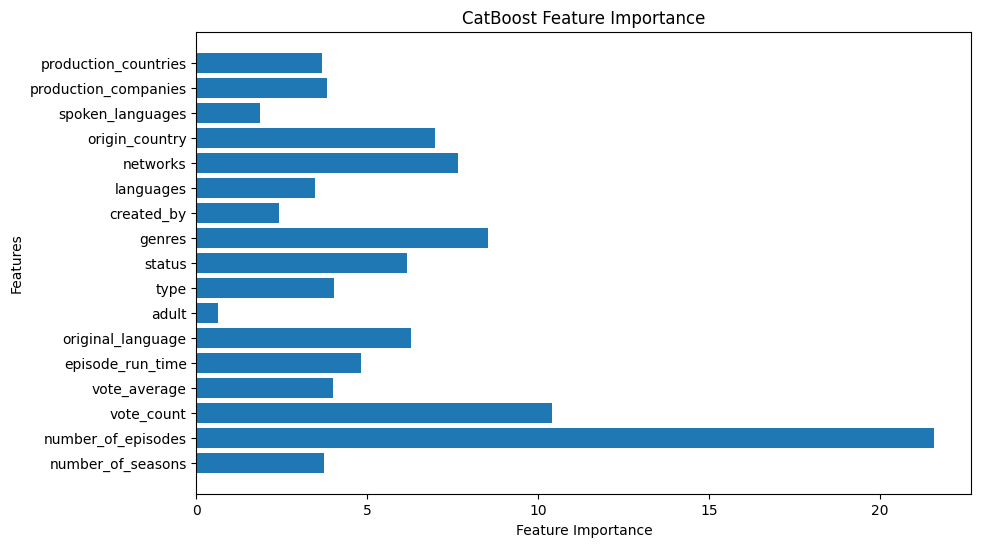

In [42]:
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor

# After training your CatBoost model
model = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.1, loss_function='RMSE', random_seed=42)
model.fit(train_pool)

# Get feature importances and plot them
feature_importances = model.get_feature_importance()
feature_names = X.columns  # Assuming X is your feature DataFrame

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.show()


Shap Values (SHAP for CatBoost)
SHAP values (SHapley Additive exPlanations) help interpret how individual features impact each prediction. CatBoost integrates SHAP, allowing you to plot SHAP values easily.

/Users/jonathanvergonio/Documents/GitHub/directv_tvrec/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


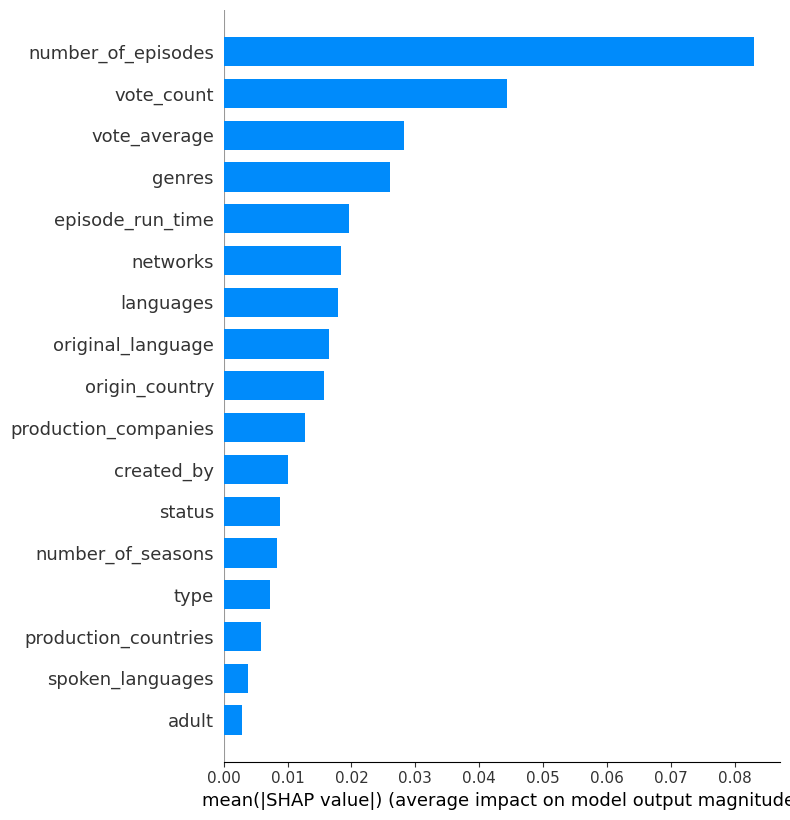

In [43]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot of SHAP values for all features
shap.summary_plot(shap_values, X, plot_type="bar")

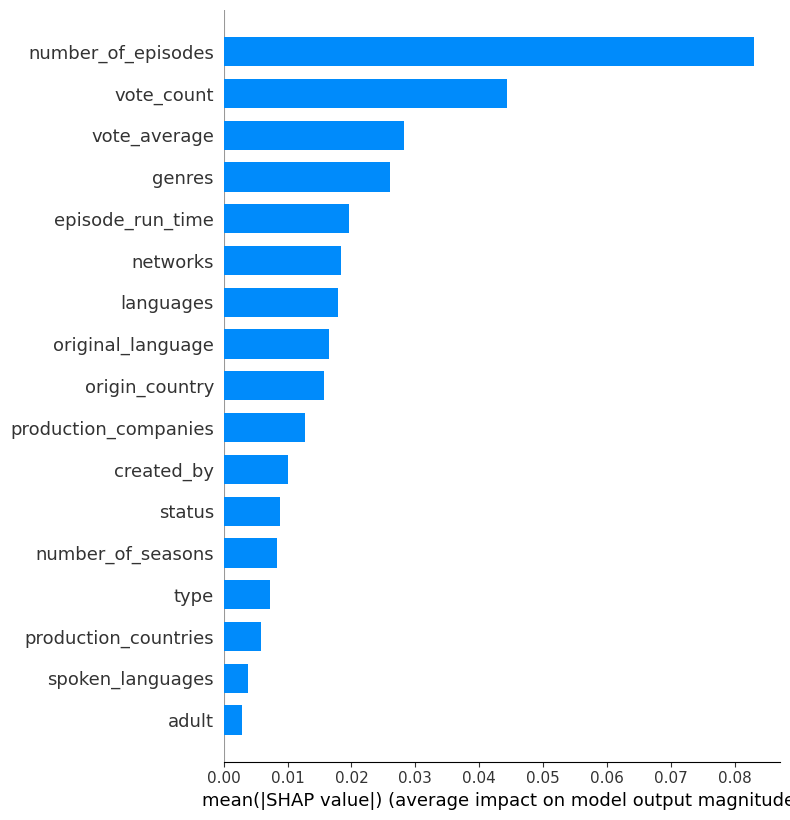

In [44]:
import shap
import matplotlib.pyplot as plt

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Set up a smaller figure size using matplotlib before calling shap.summary_plot
plt.figure(figsize=(8, 6))  # Adjust width and height as needed

# Summary plot of SHAP values
shap.summary_plot(shap_values, X, plot_type="bar", show=False)

# Show the plot
plt.show()

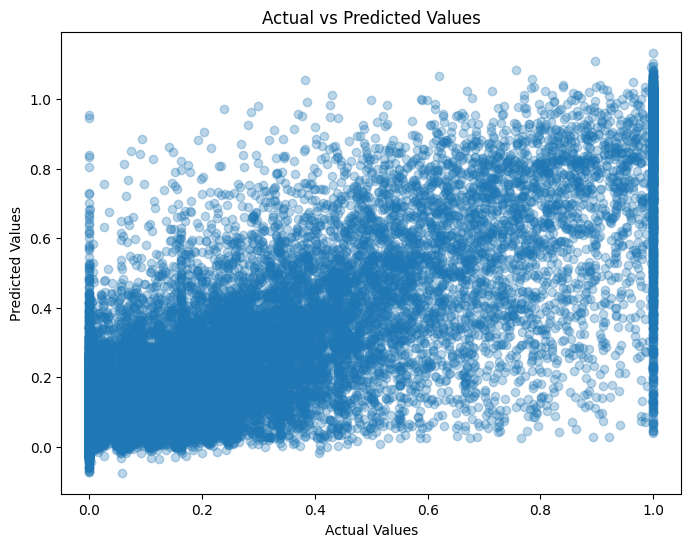

In [45]:
# Make predictions
preds = model.predict(X_test)

# Plot predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, preds, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()